In [1]:
#########################################################################################
# Name: Hasan Şenyurt
# Student ID: 64180008
# Department: Computer Engineering
# Assignment ID: A4 - Question1
#########################################################################################
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
import datetime

plt.style.use('fivethirtyeight')
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-12-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-12-2020.csv')

In [3]:
cols = confirmed_df.keys()

confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()

mortality_rate = []
recovery_rate = [] 
turkey_cases = []
turkey_deaths = []
turkey_recoveries = []

In [4]:
for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    
    turkey_cases.append(confirmed_df[confirmed_df['Country/Region']=='Turkey'][i].sum())
    turkey_deaths.append(deaths_df[deaths_df['Country/Region']=='Turkey'][i].sum())
    turkey_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Turkey'][i].sum())


days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)


days_in_future = 30
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-30]

start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []

In [5]:
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
    
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, turkey_cases, test_size=0.36, shuffle=False)

In [6]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)

In [7]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [8]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)

In [9]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

In [10]:
bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

bayesian_search.best_params_

bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished


In [11]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

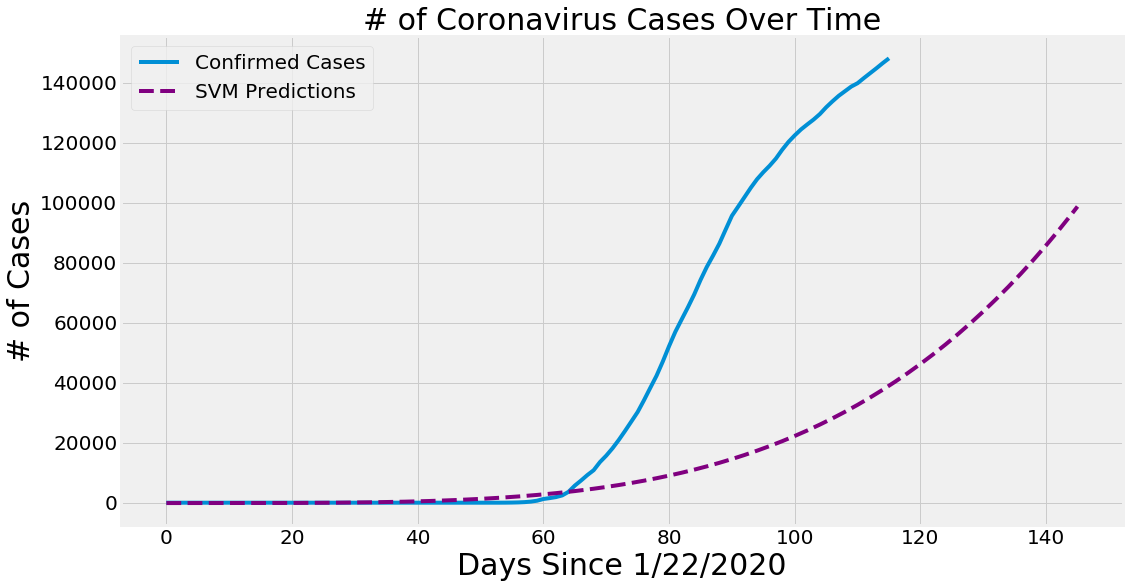

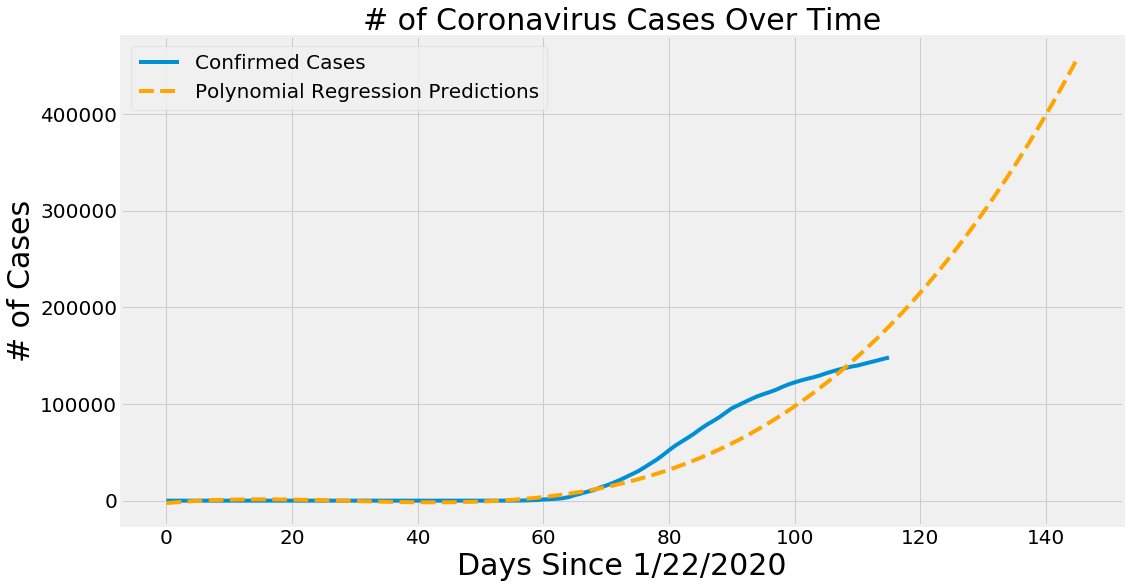

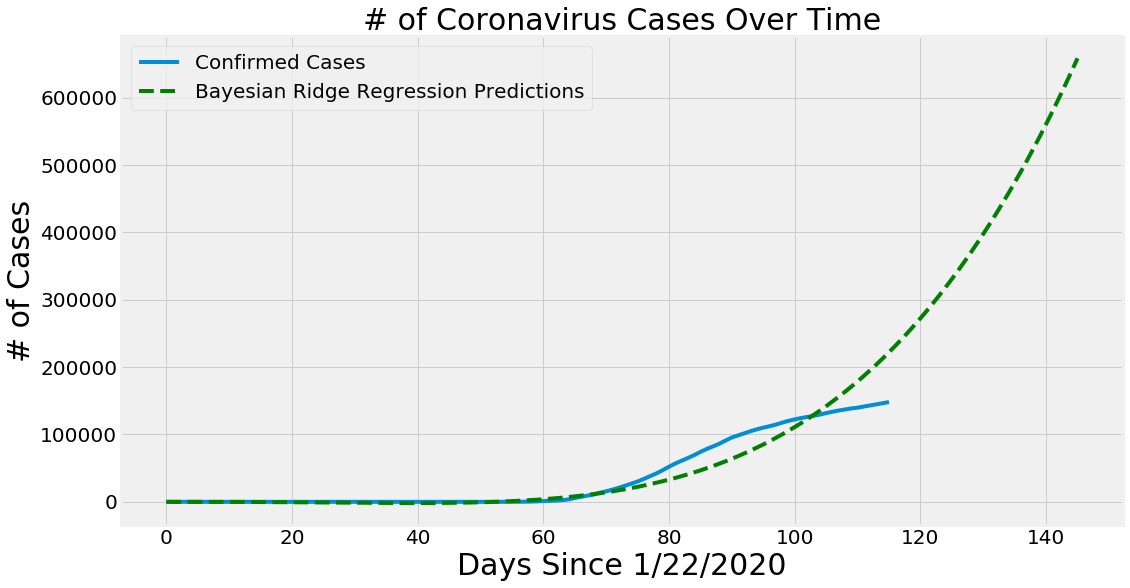

In [12]:
plot_predictions(adjusted_dates, turkey_cases, svm_pred, 'SVM Predictions', 'purple')
plot_predictions(adjusted_dates, turkey_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')
plot_predictions(adjusted_dates, turkey_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')